# Jugsolver - Jigsaw Puzzle Companion

Jigsolver's goal is to determine the most likely set of locations a jigsaw piece would fit in a jigsaw puzzle.


## References

1. [Abid K's OpenCV Tutorial](https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_tutorials.html)
2. [hackNY 2013 Entry](https://github.com/conradev/JigSolver)
3. [SIFT Wiki Page](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform)
4. [Some Stanford slides Jai sent me](http://cvgl.stanford.edu/teaching/cs231a_winter1415/lecture/lecture10_detector_descriptors_2015.pdf)

In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def render_img(img, gray=True):
    """Handy function to plot images"""
    if gray:
        plt.subplot(121),plt.imshow(img,cmap = 'gray')
    else:
        plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

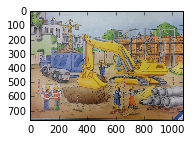

In [3]:
# Import our game board
canvas = cv2.imread('./data/box_med.jpg')
# canvas = cv2.imread('./data/board_raw.jpg')
render_img(canvas, False)

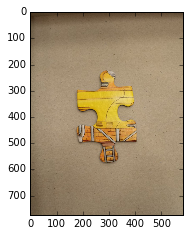

In [4]:
# Import our piece (we are going to use a clump for now)
piece = cv2.imread('./data/piece_small.jpg')
# piece = cv2.imread('./data/piece.jpg')
render_img(piece, False)

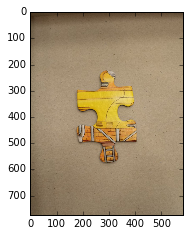

In [11]:
# Pre-process the piece
def identify_contour(piece, threshold_low=150, threshold_high=255):
    """Identify the contour around the piece"""
    piece = cv2.cvtColor(piece, cv2.COLOR_BGR2GRAY) # better in grayscale
    ret, thresh = cv2.threshold(piece, threshold_low, threshold_high, 0)
    image, contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_sorted = np.argsort(map(cv2.contourArea, contours))
    return contours, contour_sorted[-2]

def get_bounding_rect(contour):
    """Return the bounding rectangle given a contour"""
    x,y,w,h = cv2.boundingRect(contour)
    return x, y, w, h

# Get the contours
contours, contour_index = identify_contour(piece.copy())

# Get a bounding box around the piece
x, y, w, h = get_bounding_rect(contours[contour_index])
cropped_piece = piece.copy()[y:y+h, x:x+w]

# Get what's inside
# mask = cv2.drawContours(piece.copy(), contours, contour_index, (255,255,255), -1) # -1 thickness means fill it

further_cropped_piece = cropped_piece.copy()

# print cropped_piece.shape
# print further_cropped_piece.shape

processed_piece = piece.copy()
render_img(processed_piece, False)


## First Approach: Template Matching

In [12]:
# Initiate SIFT detector
# OpenCV3 has moved things around, ref this article
# http://www.pyimagesearch.com/2015/07/16/where-did-sift-and-surf-go-in-opencv-3/

# Initiate SIFT detector
sift =  cv2.xfeatures2d.SIFT_create()

img1 = processed_piece.copy() # queryImage
img2 = canvas.copy() # trainImage

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
#     good.append(m)
    if m.distance < 0.7*n.distance:
        good.append(m)

In [13]:
MIN_MATCH_COUNT = 10

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    d,h,w = img1.shape[::-1]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

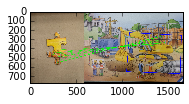

In [14]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
cv2.imwrite('./output/solution.jpg', img3)
render_img(img3, False)